# Robustness plot for PCGMM 

In [1]:
from importlib import reload
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import latgmm.geoplot as gpl

## Conditional probabilities

In [2]:
robustness_prob = [
    dict(name='SSTA',               path="../output/pcgmm/pcgmm_weights_mean_sst.nc"),
    dict(name='SSTA lat=(-15,15)',  path="../output/pcgmm/pcgmm_weights_mean_sst_lon_[-15,15].nc"),
    dict(name='SSTA+SSHA',          path="../output/pcgmm/pcgmm_weights_mean_sst_ssh.nc"),
    dict(name='Nonlinear',          path="../output/aegmm/aegmm_weights_mean_sst_lat_30.nc"),
]

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


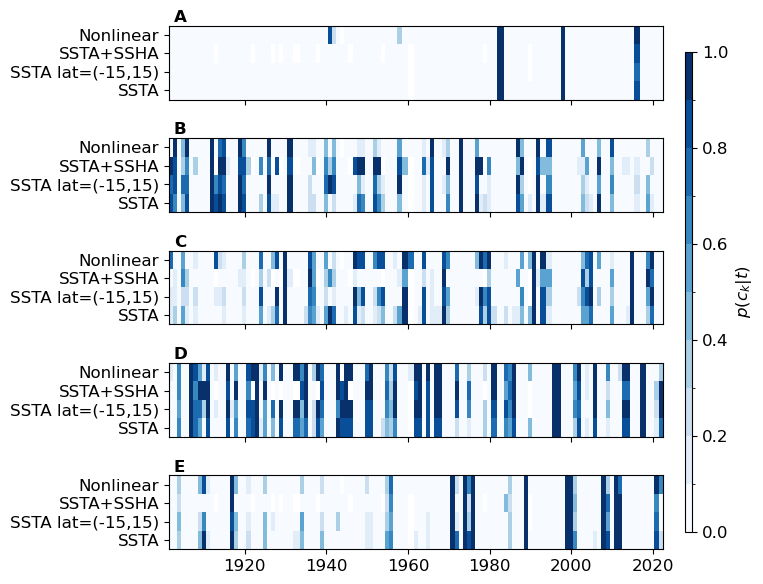

In [3]:
n_rows = 5
fig, axs = plt.subplots(n_rows, 1, figsize=(7, 1.2*n_rows), sharex='col', sharey='row')

for i in range(n_rows):
    compare_weights = []
    keys = []
    for dic in robustness_prob:
        p_c_given_x = xr.open_dataarray(dic['path'])
        p_c_given_x = p_c_given_x.sel(time=slice('1901-01-01', None)) 
        gmm_order = p_c_given_x.attrs['gmm_sort']
        compare_weights.append(p_c_given_x.sel(classes=gmm_order[i]+1))
        keys.append(dic['name'])

    compare_weights = xr.concat(compare_weights, dim=pd.Index(keys, name='models'))

    bounds = np.arange(0, 1.1, .1)
    cmap = plt.get_cmap("Blues")
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N)
    im = axs[i].pcolormesh(compare_weights['time'].data, compare_weights['models'].data, 
                      compare_weights.data, cmap=cmap, norm=norm
                      )
cbar_ax = fig.add_axes([0.99, .1, 0.01, 0.8])
cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cb.set_label(label=r'$p(c_k|t)$')

gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.05, fontsize=12)

## GMM mean maps

In [4]:
gmm_dict = {
    'Nonlinear':         "../output/aegmm/aegmm_means_sst_lat_30.nc",
    'SSTA lat=(-15,15)': "../output/pcgmm/pcgmm_means_sst_lat_15.nc",
    'SSTA+SSH':          "../output/pcgmm/pcgmm_means_sst_ssh.nc",
}

/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


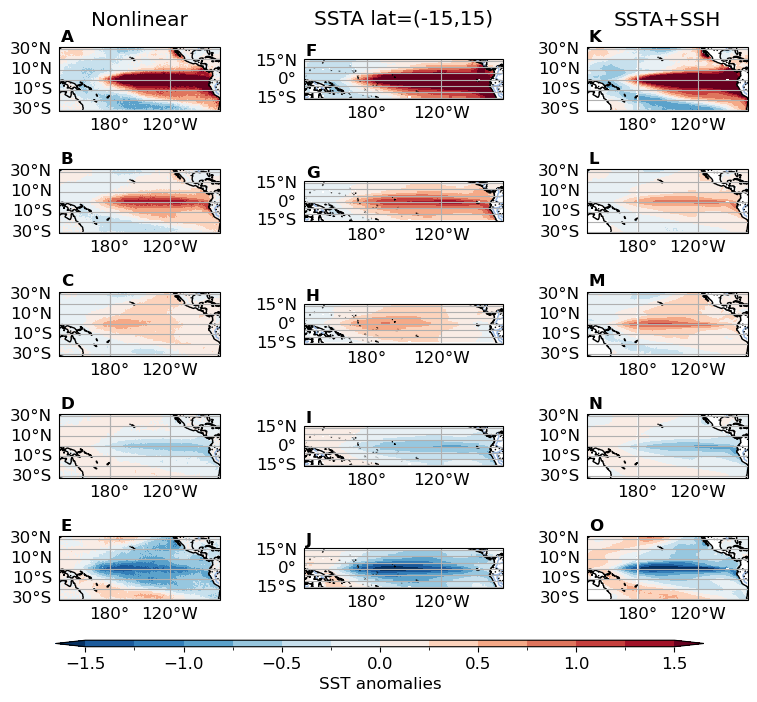

In [5]:
# Plot mean of Gaussian mixtures
import cartopy as ctp

plparam = {
    'ssta': dict(vmin=-1.5, vmax=1.5, step=0.25, cmap='RdBu_r'),
    'ssha': dict(vmin=-.15, vmax=.15, step=0.25, cmap='RdGy_r'),
}

var = 'ssta'
nrow = 5 
ncol = len(gmm_dict)
fig = plt.figure(figsize=(ncol*2.7, 1.3*nrow))
proj = ctp.crs.PlateCarree(central_longitude=180)

axs = []
for i, (key, path) in enumerate(gmm_dict.items()):
    means = xr.open_dataset(path)
    gmm_order = means.attrs['gmm_sort']
    for j, k in enumerate(gmm_order):
        idx = ncol*j+i+1
        ax = fig.add_subplot(nrow, ncol, idx, projection=proj)
        im = gpl.plot_map(means.sel(mu=k)[var], central_longitude=180, ax=ax, 
                         add_bar=False, bar='discrete', **plparam[var], 
                         kwargs_cb={'orientation': 'vertical', 'shrink':0.8, 'extend': 'both',
                                    "label": rf"$d(\mu (k={k+1}))$"})
        im['gl'].top_labels = False 
        if j == 0:
            if i == 1:
                ax.set_title(f"{key}", y=1.65)
            else:
                ax.set_title(f"{key}", y=1.2)
        
        axs.append(ax)

cbar_ax = fig.add_axes([0.1, -.01, 0.8, 0.01])
cb = fig.colorbar(im['im'], cax=cbar_ax, orientation='horizontal', extend='both')
cb.set_label(label=fr"SST anomalies")

_ = gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.08, fontsize=12)